# LinkedIn Jobs analysis with Spacy

In [1]:
import pandas as pd
import numpy as np
import json

#spacy
import spacy
from spacy.pipeline import EntityRuler
# from spacy.lang.en import English
from spacy.cli import download

#Visualization
import matplotlib.pyplot as plt
from spacy import displacy
import plotly
import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from wordcloud import WordCloud

#warning
import warnings 
warnings.filterwarnings('ignore')

# Load dataset (scraped Linkedin Jobs)

In [2]:
jobs_df = pd.read_json("/Users/Jason/Desktop/is3107/is3107_DataEngineering/LinkedIn_WebScraping/linkedin_jobs.json", convert_dates=['posted_date','scraping_date'])
jobs_df.head()

,url,Job_txt,company,job-title,level,location
0,https://www.linkedin.com/jobs/collections/reco...,Senior Business Intelligence (BI) Data Analyst...,Dyson,Senior Business Intelligence (BI) Data Analyst,Mid-Senior level,"Singapore, Singapore"
1,https://www.linkedin.com/jobs/collections/reco...,"Senior Compliance Data Analyst, CEO Office OKX...",OKX,"Senior Compliance Data Analyst, CEO Office",Executive,Singapore
2,https://www.linkedin.com/jobs/collections/reco...,"Data Governance Analyst Certis Singapore, Sing...",Certis,Data Governance Analyst,Mid-Senior level,"Singapore, Singapore"
3,https://www.linkedin.com/jobs/collections/reco...,Data Engineering Analyst Avensys Consulting Si...,Avensys Consulting,Data Engineering Analyst,Mid-Senior level,"Singapore, Singapore"
4,https://www.linkedin.com/jobs/collections/reco...,Senior Data Analyst - Institutional Data OKX S...,OKX,Senior Data Analyst - Institutional Data,Associate,Singapore


# Create a jsonl file containing the skill patterns that can be used to create spaCy entity_ruler

The list of skills is converted from txt file to jsonl file as follows:

In [5]:
###################################################################################
# Convert skills (txt format) to patterns (jsonl format)
# patterns: ie. words used to descibe skills)
###################################################################################
# 1. Get list of skills from txt file
file_txt = open("Skills_in_Demand.txt", 'r',encoding='cp1252')
list_skills_in_demand = []
for x in file_txt.readlines():
    list_skills_in_demand.append(x.strip())
file_txt.close()

# 2. Create the skill patterns
rule_patterns = []
for skill in list_skills_in_demand:
    pattren = []
    for elt in skill.split(" "):
        pattren.append({"LOWER":elt})
        
    json_data = {"label":"SKILL","pattern":pattren}
    # Convert the dictionary to a JSON string with double quotes
    json_string = json.dumps(json_data,ensure_ascii=True)
    rule_patterns.append(json_string)

# 3. Save patterns to jsonl file
file_jsonl = open("Skill_patterns.jsonl", "w")
for k in range(len(rule_patterns)):
    file_jsonl.write(rule_patterns[k]+"\n")
file_jsonl.close()
 
# # Checking if the data is
# file_jsonl = open("../data/Skill_patterns.jsonl", 'r')
# print(file_jsonl.read())
# file_jsonl.close()

print("jsonl file created!")

jsonl file created!


In [4]:
# ###################################################################################
# # update skills (txt format)
# ###################################################################################
# # 1. Get list of skills from txt file
# file_txt = open("../data/Skills_in_Demand.txt", 'r')
# list_skills_in_demand = []
# for x in file_txt.readlines():
#     list_skills_in_demand.append(x.strip())
# file_txt.close()

# # 2. Add new Skills
# new_skills_in_demand = ["Glue" , "EMR" , "Cloud Trail" , "Cloud Watch" , "SNS" , "SQS" , "S3" , "EC2" , "RDS" , "Redshift" , "Athena",
# "AWS services", "AWS Developer", "AWS" , "Azure" , "GCP", "Power BI", "Scikit - learn", "Seaborn" , "Matplotlib" , "Streamlit"]

# for new_skill in new_skills_in_demand:
#     list_skills_in_demand.append((new_skill.lower()))
    
# list_skills_in_demand = list(set(list_skills_in_demand))

# # 3. Save updatetd list_skills_in_demand to txt file
# with open("../data/Skills_in_Demand.txt", 'w+') as f:
#     for skill in list_skills_in_demand:
#         f.write('%s\n' %skill) 
# f.close()

# Loading spaCy model

In [6]:
# # Download en_core_web_lg  
# !python -m spacy download en_core_web_lg 
download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

skill_pattern_path = "Skill_patterns.jsonl"

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


# Create spaCy entity_ruler
To create an entity ruler, we need to add a pipeline and then load the .jsonl file containing the skills into the ruler.

In [7]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [8]:
# print ruler patterns
ruler.patterns[-10:]

[{'label': 'SKILL', 'pattern': [{'LOWER': 'framework7'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'intelligent'}, {'LOWER': 'agent'}]},
 {'label': 'SKILL',
  'pattern': [{'LOWER': 'azure'},
   {'LOWER': 'machine'},
   {'LOWER': 'learning'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'system'}, {'LOWER': 'testing'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'mina'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'svn'}, {'LOWER': '(subversion)'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'control'}, {'LOWER': 'theory'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'encoding'}, {'LOWER': '(memory)'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'nativescript'}]},
 {'label': 'SKILL', 'pattern': [{'LOWER': 'swiftype'}]}]

### Create new feature called 'skills'

In [9]:
def get_skills(text):
    doc = nlp(text)
    list_skills = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            list_skills.append(ent.text.lower())  # lower
    return list_skills

def unique_skills(list_skills):
    return list(set(list_skills))

In [10]:
# Apply functions to our dataset

jobs_df["skills"] = jobs_df["Job_txt"].str.lower().apply(get_skills) # All skill patterns are lowercase.
jobs_df["skills"] = jobs_df["skills"].apply(unique_skills)

In [11]:
# save updated DataFrame to json file
jobs_df.to_json("linkedin_jobs_scraped.json")
jobs_df.head()

,url,Job_txt,company,job-title,level,location,skills
0,https://www.linkedin.com/jobs/collections/reco...,Senior Business Intelligence (BI) Data Analyst...,Dyson,Senior Business Intelligence (BI) Data Analyst,Mid-Senior level,"Singapore, Singapore","[security, data quality, computer science, bus..."
1,https://www.linkedin.com/jobs/collections/reco...,"Senior Compliance Data Analyst, CEO Office OKX...",OKX,"Senior Compliance Data Analyst, CEO Office",Executive,Singapore,"[business, python, data mining, finance, decis..."
2,https://www.linkedin.com/jobs/collections/reco...,"Data Governance Analyst Certis Singapore, Sing...",Certis,Data Governance Analyst,Mid-Senior level,"Singapore, Singapore","[security, data quality, data management, data..."
3,https://www.linkedin.com/jobs/collections/reco...,Data Engineering Analyst Avensys Consulting Si...,Avensys Consulting,Data Engineering Analyst,Mid-Senior level,"Singapore, Singapore","[data quality, languages, hadoop, databases, c..."
4,https://www.linkedin.com/jobs/collections/reco...,Senior Data Analyst - Institutional Data OKX S...,OKX,Senior Data Analyst - Institutional Data,Associate,Singapore,"[blockchain, data visualization, data analysis..."


# Visualization

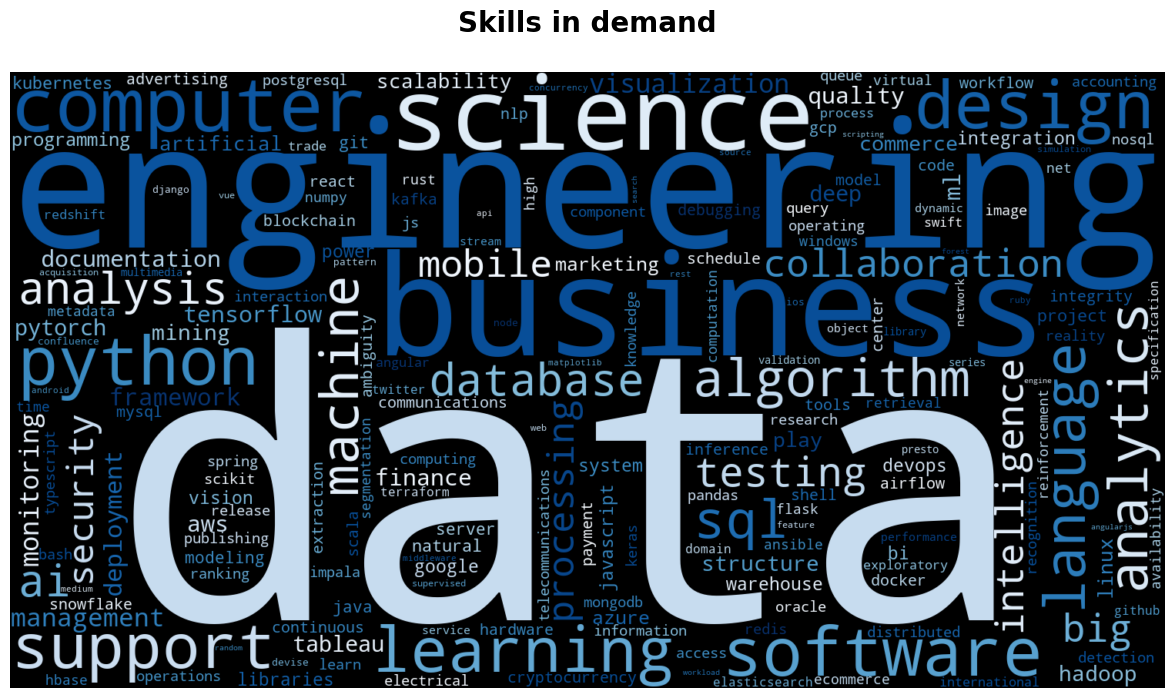

In [12]:
# 1. WordCloud (Skills in demand)

list_skills = []
for skills in jobs_df.skills.values:
    for skill in skills:
        list_skills.append(skill)

list_skills = " ".join(list_skills) # convert to str

wordcloud = WordCloud(background_color='black',max_words=200,
                      width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
wordcloud.generate(list_skills)

# display the wordcloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Skills in demand\n",size = 20, weight = 'bold');

As you can see, in addition to Python, data analytics and machine learning, skills such as security and business are in high demand for data science positions. 

Please note that this takeaway is for the Linkedin jobs that were found in Montreal on the 25th of November.

In [14]:
# 2. Level distribution

level_counts = jobs_df.groupby('level').count()['url'].sort_values(ascending=False)

blue = cl.flipper()['seq']['9']['Blues']
red = cl.flipper()['seq']['9']['Reds']
colors = [blue[5], red[3], blue[3], red[4]]
fig = go.Figure(data=[go.Pie(labels=list(level_counts.index),
                             values=level_counts,hole=0.5,
                             marker={"colors": colors},
                             sort=False,)],
                layout={'title': 'Level Distribution',
                        'showlegend': True,
                        'hoverlabel': dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"),
                        'legend': {'orientation': 'h', 'xanchor': "center", 'x': 0.5, 'y': -0.15}
                      }                    
               )
fig.show()

# Entity Recognition

Using Spacy's `Entity Recognition` capabilities and displacy.render, we can display different entities within text, e.g. skills, ORGs, GEPs...

In [30]:
job_example = jobs_df.iloc[6]
job_txt_example = job_example['Job_txt']
required_skills_example = job_example['skills']
missing_skills_example = job_example['missing_skills']

In [28]:
displacy.render(nlp(job_txt_example), style="ent", jupyter=True)

## Custom Entity Recognition

We can customize our Entity Recognition as follows:

- Add a job level (entry level, mid-senior level...) to the entity ruler.
- Add custom colours to all categories.

In [17]:
Job_levels = jobs_df.level.unique()
for a in Job_levels:
    print(a)
    ruler.add_patterns([{"label": "Job-level", "pattern": a}])

Mid-Senior level
Executive
Associate
Entry level
Not Applicable
Internship
Director


In [18]:
colors = {
    "SKILL": "linear-gradient(90deg,#9BE15D, #00E3AE)",    
    "Job-level": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "ORG": "lightgray", # None: for no color
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0", 
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": ["SKILL",
             "Job-level",
             "ORG",
             "PERSON",
             "GPE",
             "DATE",
             "PRODUCT",
    ],
    "colors": colors,
}

In [19]:
displacy.render(nlp(job_txt_example), style="ent", jupyter=True,options=options)

🔑 **Note:** 

> As we can see, some skills are mapped as ORG (such as Machine Learning and Computer Vision).
>
> Since our goal is to match and highlight all skills, we can reload spacy model and **disable the NER entity.**

In [20]:
nlp_without_NER = spacy.load("en_core_web_lg", disable = ['ner']) 

ruler_without_NER = nlp_without_NER.add_pipe("entity_ruler")
ruler_without_NER.from_disk(skill_pattern_path)

nlp_without_NER.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler']

In [21]:
# Highligh all the skills using nlp_without_NER model

displacy.render(nlp_without_NER(job_txt_example), style="ent", jupyter=True,options=options)

🔑 **Note:** 

As we can see, the model has successfully highlighted all the skills required for the job.

# Match Score

To help you get the jobs that best match your skills, we match job requirements to your skills in this section.

You can either specify your skills (str format) or analyze your resume (pdf format) to extract them.

In [22]:
# 1. Feel free to update the list of your skills.
# format: comma-separated string
your_skills = "flask,Scikit-learn,Tableau,marketing,Apache Spark,analytics,support,machine learning,data visualization,\
business,sql,data analysis,tensorflow,database,data science,java,python"

your_skills = your_skills.lower()
your_skills

'flask,scikit-learn,tableau,marketing,apache spark,analytics,support,machine learning,data visualization,business,sql,data analysis,tensorflow,database,data science,java,python'

In [24]:
# # 2. Get your skills from your resume (pdf file)

# from pdf_reader import pdf_miner
# resume_txt = pdf_miner("../data/resume_skills_example.pdf")
 
# your_skills = unique_skills(get_skills(resume_txt))
# your_skills = ",".join(your_skills)
# your_skills

### Calculate the percentage of match skills

In [23]:
from spacy.matcher import Matcher

def get_match_score(job_skills, your_skills):
    """get a percentage of match skills.
    Inputs:
    - Job_skills (list): list of required skills.
    - your_skills (str): your skills (comma separated)
    """
    # convert your skills to list
    list_your_skills = your_skills.split(",")

    score = 0
    for x in job_skills:
        if x in your_skills:
            score += 1
    job_skills_len = len(job_skills)
    try:
        match_score = round(score / job_skills_len * 100, 1)
    except:
        match_score = None
    return match_score


def get_missing_skills(list_job_skills, str_your_skills, return_list=True):
    """Get job skills that are not on your skill list."""
    
    # convert your skills form str to List
    list_your_skills = str_your_skills.split(",")
    # convert your skills to lowercase
    list_your_skills = [str.lower(skill) for skill in list_your_skills]

    missing_skills = []

    for x in list_job_skills:
        if str.lower(x) not in list_your_skills:
            try:
                missing_skills.append(x)
            except:
                pass
    if return_list:
        return missing_skills  # return list
    else:
        return ",".join(missing_skills)  # return str

In [31]:
jobs_df["match_score"] = np.vectorize(get_match_score)(jobs_df["skills"], your_skills)
jobs_df["missing_skills"] = np.vectorize(get_missing_skills)(jobs_df["skills"], your_skills, return_list=False)
jobs_df = jobs_df.sort_values(by="match_score", ascending=False)

The following jobs are the best match for your skills:

In [32]:
# Feel free to update filters
jobs_df[jobs_df.level=="Mid-Senior level"].head(5)

,url,Job_txt,company,job-title,level,location,skills,match_score,missing_skills
53,https://www.linkedin.com/jobs/collections/reco...,"Data Analyst, Patient Experience JurongHealth ...",JurongHealth Campus,"Data Analyst, Patient Experience",Mid-Senior level,"Jurong East, West Region, Singapore",[support],100.0,
126,https://www.linkedin.com/jobs/collections/reco...,"Senior E-commerce Data Analyst, Global Operati...",SHEIN,"Senior E-commerce Data Analyst, Global Operati...",Mid-Senior level,"Singapore, Singapore","[data analysis, commerce, support, business, m...",80.0,commerce
194,https://www.linkedin.com/jobs/collections/reco...,Business Intelligence Analyst (Operations) - S...,Shopee,Business Intelligence Analyst (Operations) - S...,Mid-Senior level,"Singapore, Singapore","[data analysis, tableau, sql, business intelli...",70.0,"business intelligence,algorithms,google sheets"
210,https://www.linkedin.com/jobs/collections/reco...,Business Intelligence Analyst - SG Business In...,Shopee,Business Intelligence Analyst - SG Business In...,Mid-Senior level,"Singapore, Singapore","[data analysis, tableau, sql, business intelli...",70.0,"business intelligence,algorithms,google sheets"
263,https://www.linkedin.com/jobs/collections/reco...,Senior Data Scientist Manulife Singapore 1 mon...,Manulife,Senior Data Scientist,Mid-Senior level,Singapore,"[data science, engineering, support, business,...",66.7,"engineering,net"


# Display the job descreption and highlight the skills you do and you do not have

So far, we have leveraged the power of Spacy to highlight all the skills required for the job (using `displacy.render`).

Now, it's time to step things up. We will create a function to highlight the skills you have and the skills you do not have.

## spacy.matcher.Matcher

In [33]:
# 1. Import spaCy Matcher
from spacy.matcher import Matcher

# 2. Initialize the matcher with the spaCy vocabulary
matcher = Matcher(nlp.vocab)

# 3. Create patterns (https://spacy.io/usage/rule-based-matching)
# For example, imagine that your skills are ['data base','tableau', 'machine learning'].

# pattern0 = [{'TEXT': 'database'}] # the exact verbatim text of a token.
pattern1 = [{'LOWER': 'data'},{'LOWER': 'base'}] # consecutive words
pattern2 = [{'LOWER': 'sql'}] # the lowercase form of the token text.
pattern3 = [{'LOWER': 'machine'},{'LOWER': 'learning'}] # consecutive words

# 4. Add rules to matcher
matcher.add('rule_1', [pattern1])
matcher.add('rule_2', [pattern2])
matcher.add('rule_3', [pattern3])

# 5. Get list of matches
doc_example = nlp_without_NER(job_txt_example)
list_matches = matcher(doc_example)
print("list_matches:",list_matches)

list_matches: [(375134486054924901, 406, 407)]


list_matches contains list of all matches.

For each match:
- The output has three elements. The first element, "16373735*****", is the match ID. 

- The second and third elements are the positions of the matched tokens.

In [34]:
# Let's extract matched tokens: text and positions

for match_id, start, end in list_matches: # start, ned are the positions of the matched toknes in the nlp(doc)
    # Get the matched span
    matched_span = doc_example[start:end]
    print("matched_span:","'"+matched_span.text+"'",". (start_index, end_index):",(start,end))

matched_span: 'SQL' . (start_index, end_index): (406, 407)


## Create functions to to highlight the skills you have and the skills you do not have.

In [35]:
def get_pattern(skill, rule_based_matching="LOWER"):
    """
    Extract pattern from skill (str)
    https://spacy.io/usage/rule-based-matching

    Example:
    skill = java --> pattern = [{'LOWER': 'java'}]
    skill = data scince --> pattern = [{'LOWER': 'data'},{'LOWER': 'science'}] # consecutive words
    """
    skill_split = skill.split()  # example: 'data science' --> ['data', 'science']
    pattern = []
    for obj in skill_split:
        pattern.append({rule_based_matching: obj})
    return pattern


def get_matchers(list_skills, missing_skills, spacy_nlp):
    # 1. Initialize the matchers with the spaCy vocabulary
    list_missing_skills = missing_skills
    matcher_OK = Matcher(spacy_nlp.vocab)  # you have this skill
    matcher_NOK = Matcher(spacy_nlp.vocab)  # you do not have this skill

    # 2. Add patterns
    for k, skill in enumerate(list_skills):
        # print(k, skill)
        pattern = get_pattern(skill)
        # print(k, pattern)

        if skill in list_missing_skills:
            matcher_NOK.add(f"rule_{k}", [pattern])  # you do not have this skill
        else:
            matcher_OK.add(f"rule_{k}", [pattern])  # you have this skill

    return matcher_OK, matcher_NOK


def get_indexes(list_matches):
    """Get word indexes in the Spacy nlp document.
    We will leverage the list_matches, which contains the list of all matches.
    For each match, the output has three elements.
    - The first element is the match ID.
    - The second and third elements are the positions of the matched tokens."""
    list_indexes = []
    for match in list_matches:
        start_index = match[1]
        end_index = match[2]
        for k in range(start_index, end_index):
            list_indexes.append(k)
    return list_indexes


def return_words_types(job_txt, list_required_skills, list_missing_skills, spacy_nlp):
    """Returns two lists:
    - list of words
    - list of the corresponding types (skill, missing skill, other words)"""

    Job_doc_nlp = spacy_nlp(job_txt)

    # create matchers
    matcher_OK, matcher_NOK = get_matchers(
        list_required_skills, list_missing_skills, spacy_nlp
    )

    # Get list of matches
    list_matches_OK = matcher_OK(Job_doc_nlp)
    list_matches_NOK = matcher_NOK(Job_doc_nlp)

    # Get index of words using matcher_OK (ie. you have the skill)
    indexes_SKILLS_OK = get_indexes(list_matches_OK)
    # Get index of words using matcher_NOK (ie. you do not have the skill)
    indexes_SKILLS_NOK = get_indexes(list_matches_NOK)

    # Get index of other words (not Skills)
    indexes_others = []

    for k, word in enumerate(Job_doc_nlp):
        if (k in indexes_SKILLS_OK) | (k in indexes_SKILLS_NOK):
            pass
        else:
            indexes_others.append(k)

    words = []
    types = []

    for k, word in enumerate(Job_doc_nlp):
        words.append(word)
        if k in indexes_SKILLS_NOK:
            types.append("SKILL-missing")
        elif k in indexes_SKILLS_OK:
            types.append("SKILL")
        else:
            types.append("other")

    return words, types

In [36]:
words, types = return_words_types(job_txt_example, required_skills_example, missing_skills_example, nlp_without_NER)

for index,type in enumerate(types):
    if type!="other":
        print(index,words[index],":",type)

205 support : SKILL
378 Data : SKILL
379 Science : SKILL
382 Analytics : SKILL
404 Python : SKILL
496 finance : SKILL-missing
504 finance : SKILL-missing


We will use these functions in our Flask application to highlight the skills you do and do not have.

In [37]:
import base64, io, IPython
from PIL import Image as PILImage

def html_base64_image(image_path):
    '''converte image to Base64'''
    image = PILImage.open(image_path)

    output = io.BytesIO()
    image.save(output, format='PNG')
    encoded_string = base64.b64encode(output.getvalue()).decode()

    html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
    return html

IPython.display.HTML(html_base64_image("../screenshots/capture1.png"))

FileNotFoundError: [Errno 2] No such file or directory: '../screenshots/capture1.png'

We can easily see that keywords like `computer vision` and `AI` are missing from your list of skills. You might want to add these keywords to your resume (if you have these skills).